# Matrix Factorization
- <b>User-Item Matrix 를 F차원의 User와 Item의 Latent Factor 행렬곱으로 분해하는 방법</b>
- SVD와 비슷한 방법이지만, User-Item Matrix와 같이 결측값이 많은 Sparse Matrix(희소행렬)에서는 적용하기 어렵습니다.
- Train matrix factorization from scratch
- Matrix Factorization 코드는 [github](https://github.com/albertauyeung/matrix-factorization-in-python/blob/master/mf.py)을 참고했습니다.
- 본 코드는 SGD를 사용한 matrix factorization 기법입니다.

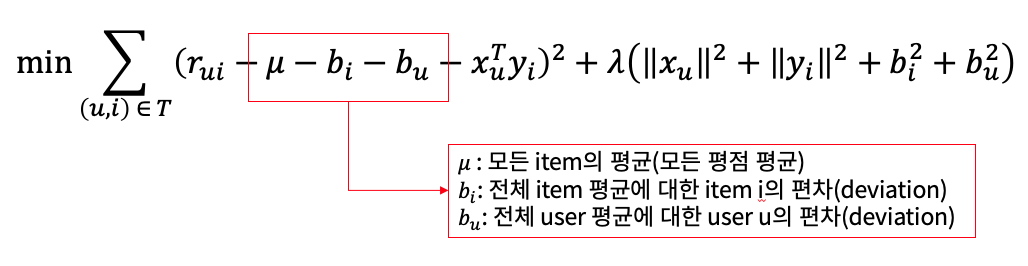

## Dataset 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [4]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [5]:
train_df = train_df[:1000]

##Sparse Matrix 만들기

In [6]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

# 결측값을 0으로 채우기
sparse_matrix = sparse_matrix.fillna(0)

# fill sparse matrix with average of movie ratings
#sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# # fill sparse matrix with average of user ratings
# sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [7]:
sparse_matrix = sparse_matrix.to_numpy()
sparse_matrix.shape

(799, 347)

## Matrix Factorization 실행하기 

- 알고리즘 학습 방법
  1. Stochastic Gradient Descent (SGD)
    - 현재 위치의 gradient 반대방향으로 값을 갱신
  2. Alternating Least Squares (ALS)
    - x, y 의 값을 둘 다 모르는 상황에서 둘 중 하나를 고정시키면 2차식의 최적화 문제로 해결할 수 있음
    - x, y를 번갈아서 고정시키며, 최소제곱문제로 해를 구함
    - Explicit data에 비해 결측치가 적은 Implicit data에서 유용함(SGD를 사용하게 되면 연산량이 증가하기 때문임)

In [8]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            # if (i+1) % 10 == 0:
            print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        #print(self.b_i[np.newaxis, :].shape, self.b_i[np.newaxis:,].shape) # dimension 비교하기
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis, :] + self.P.dot(self.Q.T) # |b|=(1,) , |b_u|=(u, 1) , |b_i|=(1, i) *b_i의 차원은 (i,)여도 broadcasting되어 잘 계산됨*, |P|=(u, k) , |Q|=(i, k) , |PQ|=(u, i)

## Train MF

In [9]:
mf = MF(sparse_matrix, K=50, alpha=0.1, beta=0.01, iterations=20)

In [10]:
training_process = mf.train()

Iteration: 1 ; error = 25.1264
Iteration: 2 ; error = 21.3890
Iteration: 3 ; error = 18.7529
Iteration: 4 ; error = 16.6059
Iteration: 5 ; error = 14.7578
Iteration: 6 ; error = 13.0904
Iteration: 7 ; error = 11.5709
Iteration: 8 ; error = 10.1502
Iteration: 9 ; error = 8.9013
Iteration: 10 ; error = 7.7605
Iteration: 11 ; error = 6.7637
Iteration: 12 ; error = 5.9035
Iteration: 13 ; error = 5.1674
Iteration: 14 ; error = 4.5381
Iteration: 15 ; error = 4.0066
Iteration: 16 ; error = 3.5510
Iteration: 17 ; error = 3.1633
Iteration: 18 ; error = 2.8265
Iteration: 19 ; error = 2.5412
Iteration: 20 ; error = 2.2951


In [11]:
mf.full_matrix()

array([[4.75362764, 4.70955633, 4.44928187, ..., 3.84931072, 3.55456484,
        3.93720023],
       [4.19899326, 4.1594218 , 3.87524897, ..., 3.30987486, 3.07662815,
        3.47067738],
       [3.71835485, 3.67275975, 3.39624173, ..., 2.83087473, 2.6041283 ,
        2.98119313],
       ...,
       [4.11462849, 4.05555049, 3.78398016, ..., 3.21864013, 2.97971865,
        3.33842752],
       [4.38700517, 4.33884781, 4.05605186, ..., 3.49728401, 3.25834172,
        3.6410316 ],
       [3.85764291, 3.81001104, 3.54566184, ..., 2.97576658, 2.75431207,
        3.09700134]])

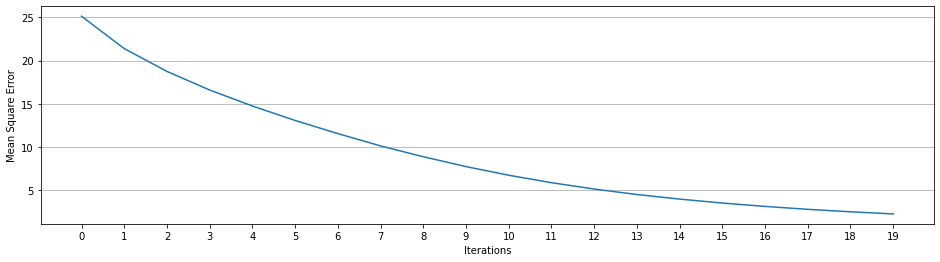

In [12]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")